In [128]:
from casadi import *

In [129]:
# Set up the problem
N = 20 # number of control intervals
opti = Opti() # optimization problem

# Declare the decision variables
X = opti.variable(3, N+1) # State trajectory
pos = X[0,:]
speed = X[1,:]
w_bal = X[2, :]
U = opti.variable(1,N) # control trajectory (power) 
T = opti.variable() # final time

In [130]:
# Parameters:
mass_rider = 78
mass_bike = 8
m = opti.parameter()
opti.set_value(m, mass_rider + mass_bike)
g = 9.81
my = 0.004
b0 = 0.091
b1 = 0.0087
Iw = 0.14
r = 0.33
Cd = 0.7
rho = 1.2
A = 0.4
eta = 1
w_prime = 26630
cp = 265
s = 0.01

In [131]:
# Set up the objective
opti.minimize(T) # race in minimal time

# System dynamics (excluding slope/gravity effect)
f = lambda x,u: vertcat(x[1], 1/x[1] * 1/(m + Iw/r**2) * (eta*u - my*m*g*x[1] - m*g*s*x[1] - b0*x[1] - b1*x[1]**2 - 0.5*Cd*rho*A*x[1]**3), -(u-cp))

In [132]:
dt = T/N # Control interval
for k in range(N): # Loop over control intervals
    k1 = f(X[:,k], U[:,k])
    k2 = f(X[:,k] + dt/2*k1, U[:,k])
    k3 = f(X[:,k] + dt/2*k2, U[:,k])
    k4 = f(X[:,k] + dt*k3, U[:,k])
    x_next = X[:,k] + dt/6*(k1+2*k2+2*k3+k4)
    opti.subject_to(X[:,k+1] == x_next)

In [133]:
# Set the path constraints
# for k in range(N): # Loop over positions
#     opti.subject_to(opti.bounded(0,pos[k],1000))

#opti.subject_to(opti.bounded(0,pos,1000))
# opti.subject_to(speed <= limit(pos)) # track speed limit
opti.subject_to(opti.bounded(1,U,500)) # control is limited

In [134]:
# Set boundary conditions
opti.subject_to(pos[0]==0) # start at position 0
opti.subject_to(speed[0]==3) 
opti.subject_to(pos[-1]==1000)
opti.subject_to(w_bal[0]==w_prime)

opti.subject_to(speed > 2)

# One extra constraint
opti.subject_to(T>=0) # time must be positive

In [135]:
# Provide an initial guess for the solver
# opti.set_initial(T, 300)
# opti.set_initial(U, 300)

In [136]:
opti

Opti(Opti {
  instance #11
  #variables: 3 (nx = 84)
  #parameters: 1 (np = 1)
  #constraints: 27 (ng = 106)
  CasADi solver needs updating.
})

In [137]:
p_opts = {"expand": True, "print_time": False}
s_opts = {"print_level": 3, 
	    "tol": 5e-1, 
	    "dual_inf_tol": 5.0, 
	    "constr_viol_tol": 1e-1,
	    "compl_inf_tol": 1e-1, 
	    "acceptable_tol": 1e-2, 
		"acceptable_constr_viol_tol": 0.01, 
		"acceptable_dual_inf_tol": 1e10,
		"acceptable_compl_inf_tol": 0.01,
		"acceptable_obj_change_tol": 1e20,
		"diverging_iterates_tol": 1e20}

opti.solver('ipopt', p_opts, s_opts)

In [138]:
# opti.solver('ipopt') # set numerical backend
sol = opti.solve() # actual solve


Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT                               = 0.001

EXIT: Invalid number in NLP function or derivative detected.


CasADi - 2024-02-15 14:21:28 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 2 (row 0, col 1).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-02-15 14:21:28 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 2 (row 0, col 1).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-02-15 14:21:28 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-02-15 14:21:28 WARNING("solver:nlp_grad failed: NaN detected for output grad_gamma_p, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-02-15 14:21:28 WARNING("Failed to calculate multipliers") [.../casadi/core/nlpsol.cpp:798]


RuntimeError: Error in Opti::solve [OptiNode] at .../casadi/core/optistack.cpp:157:
.../casadi/core/optistack_internal.cpp:996: Assertion "return_success(accept_limit)" failed:
Solver failed. You may use opti.debug.value to investigate the latest values of variables. return_status is 'Invalid_Number_Detected'

In [142]:
opti.debug.g_describe(3)

'Opti constraint of shape 3x1, defined at C:\\Users\\brokk\\AppData\\Local\\Temp\\ipykernel_20496\\1419412345.py:8\nAt nonzero 0.'

In [ ]:
opti.debug.x_describe(1)

"Opti decision variable 'opti9_x_1' of shape 3x21, defined at C:\\Users\\brokk\\AppData\\Local\\Temp\\ipykernel_20496\\2491851297.py:6\nAt nonzero 1."

In [139]:
opti.debug.show_infeasibilities

<bound method OptiAdvanced.show_infeasibilities of Opti(Opti {
  instance #11
  #variables: 3 (nx = 84)
  #parameters: 1 (np = 1)
  #constraints: 27 (ng = 106)
  CasADi solver allocated.
  CasADi solver was called: Invalid_Number_Detected
})>

In [28]:
import numpy as np

def calculate_elevation_profile(slopes, lengths):
    angles =  []
    for i, s in enumerate(slopes):
        angles += lengths[i]*[np.arctan(s)]

    elevation = np.zeros(sum(lengths))
    elevation[0] = 0
    for i in range(1,len(elevation)):
        elevation[i] = elevation[i-1] + np.sin(angles[i])
    return elevation

slopes = [0.05, 0.05, 0, -0.03, 0.08]
lengths = [500, 500, 1000, 200, 3000]
elevation = calculate_elevation_profile(slopes, lengths)
print(elevation)


[0.00000000e+00 4.99376169e-02 9.98752339e-02 ... 2.82966554e+02
 2.83046299e+02 2.83126044e+02]


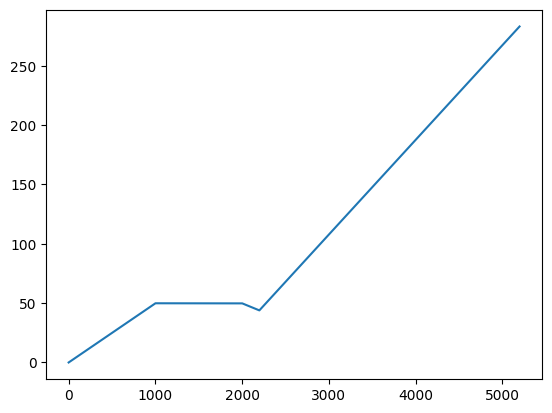

In [29]:
import matplotlib.pyplot as plt

plt.plot(elevation)

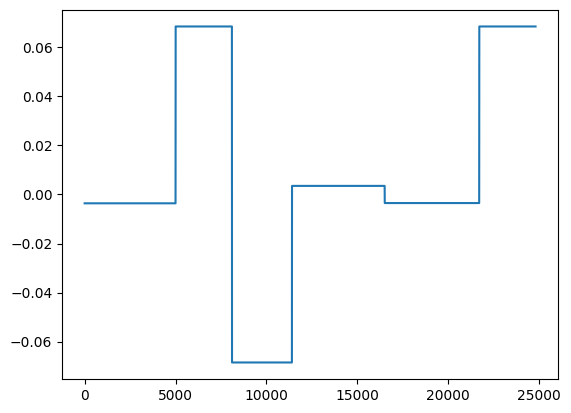

In [17]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt
from utils import *

gradients = [-0.0036, 0.0685, -0.0685, 0.0035, -0.0035, 0.0685]
distances = [5000, 3100, 3300, 5100, 5200, 3100]

slope = get_slope_arr(gradients, distances)
xgrid = np.linspace(0, len(slope), len(slope))

interpolant_casadi = ca.interpolant('Slope', 'bspline', [xgrid], slope)

plt.plot(interpolant_casadi(xgrid))
plt.show()

# xgrid = np.linspace(0,9,10)
# V = [0.05, 0.05, 0.05, 0.05, 0.05, 0.01, 0.01, 0.01, 0.01, 0.01]
# lut = ca.interpolant('LUT','bspline',[xgrid],V)
# print(lut(2.5))
# # Using SciPy
# import scipy.interpolate as ip
# interp = ip.InterpolatedUnivariateSpline(xgrid, V)
# print(interp(2.5))

# plt.plot(xgrid, V)
# plt.plot(xgrid, interp(xgrid))
# plt.show()